In [16]:
from prefect import task
import torch
from torch.nn.functional import one_hot
from bayesian_network.common.torch_settings import TorchSettings
import torchvision
from torchvision.transforms import transforms


@task
def preprocess(torch_settings: TorchSettings, gamma, selected_num_observations):
    # torch_settings = TorchSettings(torch.device("cpu"), torch.float64)

    # gamma = 0.00001
    # selected_num_observations = 1000

    mnist = torchvision.datasets.MNIST(
        "./mnist", train=True, transform=transforms.ToTensor(), download=True
    )
    data = mnist.train_data.to(torch_settings.device)

    # Make smaller selection
    if selected_num_observations:
        data = data[0:selected_num_observations, :, :]

    data = data.ge(128).long()

    height, width = data.shape[1:3]
    num_features = height * width
    num_observations = data.shape[0]

    # Morph into evidence structure
    data = data.reshape([num_observations, num_features])

    # evidence: List[num_observed_nodes x torch.Tensor[num_observations x num_states]], one-hot encoded
    evidence = [
        node_evidence * (1 - gamma) + gamma / 2
        for node_evidence in one_hot(data.T, 2).to(torch_settings.dtype)
    ]

    return evidence

In [3]:
from bayesian_network.bayesian_network import BayesianNetwork, Node
import torch
import torchvision as torchvision
from bayesian_network.bayesian_network import BayesianNetwork, Node
from bayesian_network.inference_machines.torch_sum_product_algorithm_inference_machine import \
    TorchSumProductAlgorithmInferenceMachine
from bayesian_network.interfaces import IInferenceMachine
from bayesian_network.optimizers.em_optimizer import EmOptimizer

num_observations = evidence[0].shape[0]
height = 28
width = 28
num_classes = 10

# Create network
Q = Node(torch.ones((num_classes), device=torch_settings.device, dtype=torch_settings.dtype)/num_classes, name='Q')
mu = torch.rand((height, width, num_classes), device=torch_settings.device, dtype=torch_settings.dtype)*0.2 + 0.4
mu = torch.stack([1-mu, mu], dim=3)
Ys = [
    Node(mu[iy, ix], name=f'Y_{iy}x{ix}')
    for iy in range(height)
    for ix in range(width)
]

nodes = [Q] + Ys
parents = {
    Y: [Q] for Y in Ys
}
parents[Q] = []

network = BayesianNetwork(nodes, parents)

# Train network
num_iterations = 10
num_sp_iterations = 3

def inference_machine_factory(bayesian_network: BayesianNetwork) -> IInferenceMachine:
    return TorchSumProductAlgorithmInferenceMachine(
        bayesian_network=bayesian_network,
        observed_nodes=Ys,
        torch_settings=torch_settings,
        num_iterations=num_sp_iterations,
        num_observations=num_observations,
        callback=lambda *args: None)

em_optimizer = EmOptimizer(network, inference_machine_factory)
em_optimizer.optimize(evidence, num_iterations, lambda ll, iteration, duration:
    print(f'Finished iteration {iteration}/{num_iterations} - ll: {ll} - it took: {duration} s'))
    

Finished iteration 0/10 - ll: -547763.7178622964 - it took: 0.6151092052459717 s
Finished iteration 1/10 - ll: -153989.75762816836 - it took: 0.5394320487976074 s
Finished iteration 2/10 - ll: -130917.8239689089 - it took: 0.49376487731933594 s
Finished iteration 3/10 - ll: -127040.30533309361 - it took: 0.5808491706848145 s
Finished iteration 4/10 - ll: -124447.77541068 - it took: 0.4797241687774658 s
Finished iteration 5/10 - ll: -122251.9515945247 - it took: 0.48847007751464844 s
Finished iteration 6/10 - ll: -119822.48167116674 - it took: 0.47176289558410645 s
Finished iteration 7/10 - ll: -117705.10126030666 - it took: 0.49124789237976074 s
Finished iteration 8/10 - ll: -115896.34894805076 - it took: 0.51338791847229 s
Finished iteration 9/10 - ll: -114822.19928738059 - it took: 0.4472849369049072 s


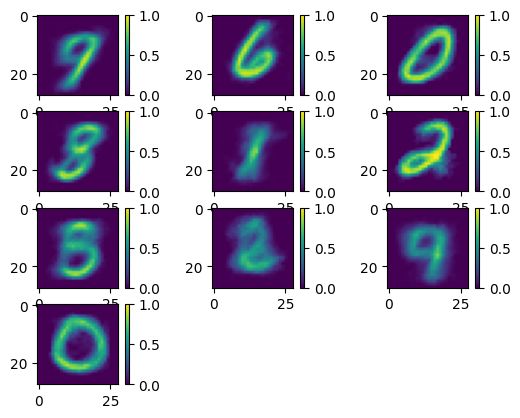

In [4]:
import torch
import matplotlib.pyplot as plt

height = 28
width = 28

Q = network.nodes[0]
Ys = network.nodes[1:]

w = torch.stack([y.cpt.cpu() for y in Ys])

plt.figure()
for i in range(0, 10):
    plt.subplot(4, 3, i+1)
    plt.imshow(w[:, i, 1].reshape(height, width))
    plt.colorbar()
    plt.clim(0, 1)
    
